In [1]:
import wmfdata as wmf
from wmfdata.utils import pd_display_all

# Contributor events

In [3]:
contributor_events = wmf.presto.run("""
SELECT
    FROM_ISO8601_TIMESTAMP(meta.dt) AS dt,
    meta.domain AS domain,
    access_method,
    context_page_title,
    event_type,
    publish_failure_message,
    story_already_exists,
    story_title,
    user_edit_count_bucket,
    user_is_anonymous,
    user_name
FROM event.mediawiki_wikistories_contribution_event
WHERE
    year >= 0
""")

In [ ]:
contributor_events.describe()

In [19]:
contributor_events["event_type"].value_counts()

story_builder_open    541
publish_success       124
publish_failure        19
Name: event_type, dtype: int64

This doesn't match up with the canonical number of story edits:
```
create new story       242
edit existing story    104
```

These edits only go back to 2022-06-30 (81 days ago), so old data won't have been purged yet.

Some edits to existing stories probably aren't captured because the user uses the "plain" textbox interface rather than the story builder (sidenote: we should add a change tag when the story builder is used.)

But the main explanation is probably ad blockers. Not much we can do about that, but something to keep in mind.

It's also strange that the all the events have `story_already_exists == False`. I'm sure someone has opened the story builder on an existing article (without an adblocker) at least once... 

In [20]:
contributor_events["access_method"].value_counts()

mobile web    682
desktop         2
Name: access_method, dtype: int64

The story builder is only accessible through the mobile web interface, but if you combine its URL path with the desktop hostname, you can load it within the desktop interface, so that's what I assumed happened with these two events.

In [ ]:
contributor_events.query("access_method == 'desktop'")

In [23]:
contributor_events["context_page_title"].value_counts().head()

Kucing                      36
Museum_Sejarah_Jawa         18
Tiram                       18
Borobudur                   17
Museum_Benteng_Vredeburg    15
Name: context_page_title, dtype: int64

In [ ]:
contributor_events["publish_failure_message"].value_counts()

In [26]:
contributor_events["story_title"].value_counts()

                                       7
Tiram                                  5
Museum Balla Lompoa                    4
P                                      4
Mengenal Museum Fatahillah Jakarta     4
                                      ..
Benteng Vredeburg 1760-1799            1
Bangunan Museum Kereta Api Ambarawa    1
Diorama Mataraman's Room               1
Koleksi Museum Kereta Api Ambarawa     1
Terbentuknya Danau Toba                1
Name: story_title, Length: 109, dtype: int64

Odd that we should have a bunch with the title being an empty string. If the page hasn't been created yet, it should be null.

In [ ]:
contributor_events.query("story_title == ''")

Ahh, all of these are publishing failures where the failure message is "Masukkan judul Wikistories" ("Enter the Wikistories title"). It seems like the submitted title is recorded with `publish_failure`, which in this case is accurately an empty string.

In [ ]:
contributor_events.query("publish_failure_message == 'Wikistories dengan judul tersebut sudah terbit. Silakan masukkan judul yang lain.'")

In [34]:
contributor_events["user_edit_count_bucket"].value_counts()

1000+      174
0          144
100-999    136
5-99       119
1-4        111
Name: user_edit_count_bucket, dtype: int64

In [ ]:
contributor_events[["user_name", "user_edit_count_bucket"]].sample(10)

All the sampled users' buckets match their real edit count. Just being thorough :)

In [ ]:
contributor_events["user_name"].value_counts().head(10)

It looks like the main cause of the mismatch between these event counts and the [list of top editors](https://docs.google.com/spreadsheets/d/11ojrMXgIopctd7_CXeoAJcLfzCLW5drW4I6b7lPl5SI/edit#gid=318426327) is not deleted stories but the fact that a couple of weeks has passed since I pulled the list. However, I should still add edits to deleted pages to my basic stats notebook.

# Consumer event

In [7]:
consumer_events = wmf.presto.run("""
SELECT
    FROM_ISO8601_TIMESTAMP(meta.dt) AS dt,
    meta.domain AS domain,
    access_method,
    activity_session_id,
    event_type,
    experiment_entry_date,
    experiment_group,
    next_story_opened,
    page_story_count,
    page_title,
    page_visible_time,
    pageview_id,
    referrer_type,
    session_days,
    session_is_first_of_day,
    story_completed,
    story_frame_count,
    story_frames_viewed,
    story_open_time,
    story_title
FROM event.mediawiki_wikistories_consumption_event
WHERE
    year >= 0
""")

In [ ]:
consumer_events.describe(include="all")

In [62]:
impressions = consumer_events.query("event_type == 'story_impression'")[[
    "dt",
    "domain",
    "access_method",
    "activity_session_id",
    "page_story_count",
    "page_title",
    "pageview_id"
]]

In [64]:
impressions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 1 to 1248
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dt                   799 non-null    object
 1   domain               799 non-null    object
 2   access_method        799 non-null    object
 3   activity_session_id  799 non-null    object
 4   page_story_count     799 non-null    int64 
 5   page_title           799 non-null    object
 6   pageview_id          799 non-null    object
dtypes: int64(1), object(6)
memory usage: 49.9+ KB


In [ ]:
impressions.describe(include="all")

In [91]:
views = consumer_events.query("event_type == 'story_view'")[[
    "dt",
    "domain",
    "access_method",
    "activity_session_id",
    "event_type",
    "page_story_count",
    "page_title",
    "pageview_id",
    "story_completed",
    "story_frame_count",
    "story_frames_viewed",
    "story_open_time",
    "story_title"
]]

In [ ]:
views.describe(include="all")

In [ ]:
views.sample(5)

Each pageview where we have events has an impression, which is good.

In [74]:
(
    consumer_events
    .groupby("pageview_id")
    ["event_type"]
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
    ["story_impression"]
    .all()
)

True

Histogram of the number of story views per pageview:

<AxesSubplot:ylabel='Frequency'>

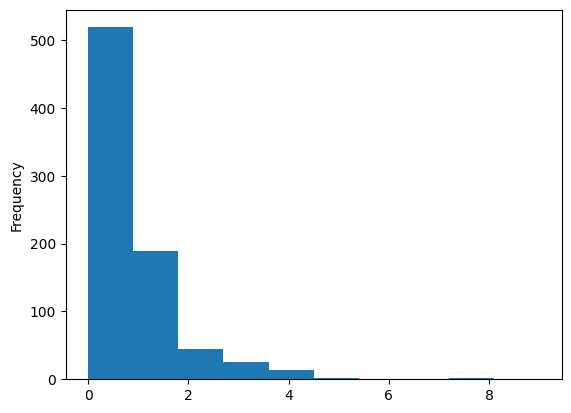

In [89]:
(
    consumer_events
    .groupby("pageview_id")
    ["event_type"]
    .value_counts()
    .unstack()
    .fillna(0)
    .astype(int)
    ["story_view"]
    .plot.hist()
)

In [76]:
views["story_title"].value_counts().head(10)

Koleksi Museum History of Java             21
Artikel yang baru saja saya terjemahkan    15
Tiram                                      14
Kunjungan                                  12
Kucing peliharaan                          11
Sekilas Museum Balla Lompoa                11
Museum Balla Lompoa                        11
Refleks pelempengan kucing                  9
Bangunan Monumen Nasional                   9
Mengenal Museum Fatahillah Jakarta          9
Name: story_title, dtype: int64

In [77]:
views["page_title"].value_counts().head(10)

Kucing                       48
Museum_Sejarah_Jawa          38
Borobudur                    29
Museum_Benteng_Vredeburg     22
Museum_Balla_Lompoa          22
Tiram                        19
Meraxes_gigas                15
Museum_Nasional_Indonesia    14
Indonesia                    11
Monumen_Nasional              9
Name: page_title, dtype: int64

History of story open times less than 100 seconds:

<AxesSubplot:ylabel='Frequency'>

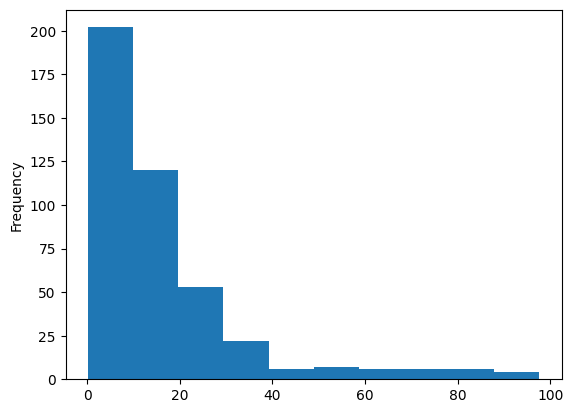

In [84]:
(views["story_open_time"] / 1000)[lambda x: x < 100].plot.hist()

Story open times of 100 seconds or more:

In [85]:
(views["story_open_time"] / 1000)[lambda x: x >= 100]

385     128.975
387     825.737
441     150.629
467     133.126
544     167.364
708     299.616
861     159.592
869     129.039
873     340.937
886     300.282
915     328.802
954     132.456
964     400.696
968     198.878
980     153.962
1011    106.771
1106    102.033
1126    133.806
Name: story_open_time, dtype: float64